# Alarm Kicker RL agent <a class="tocSkip">

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm, trange
from IPython.display import display, clear_output


ooo
ooo
ooo



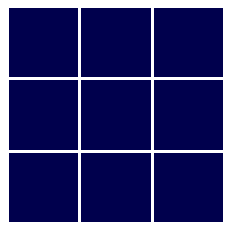

In [2]:
from environments.alarms import AlarmsEnv

env = AlarmsEnv()
s = env.reset()
env.render(plot=True)

reward: -13, done False
 Turn off (2,2)
***
***
**o



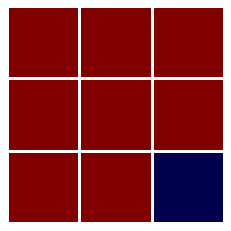

In [6]:
# agent always turning of the bottom right alarm
rewards = []
for i in trange(20):
    clear_output(wait=True)
    s, r, d, _ = env.step(8)
    rewards.append(r)
    print(f"reward: {r}, done {d} \n")
    env.render(plot=True)
    time.sleep(0.5)
    if d:
        break

In [7]:
rewards

[-6,
 -7,
 -8,
 -9,
 -10,
 -10,
 4,
 -11,
 -11,
 -11,
 -11,
 -11,
 -12,
 -12,
 -12,
 -12,
 -13,
 -13,
 -13,
 -13]

In [10]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

# hyperparameters
hidden_size = 256
learning_rate = 3e-4

# Constants
GAMMA = 0.99
num_steps = 500
max_episodes = 1000

In [18]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

In [24]:
from environments.alarms import AlarmsEnv

# Define env
env = AlarmsEnv()
# Start a2c
num_inputs = env.decode(env.reset()).size # the pixels
num_outputs = env.action_space.n

actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

all_lengths = []
average_lengths = []
all_rewards = []
entropy_term = 0

for episode in trange(max_episodes):
    log_probs = []
    values = []
    rewards = []

    state = env.reset()
    for steps in range(num_steps):
        value, policy_dist = actor_critic.forward(env.decode(state).ravel())
        value = value.detach().numpy()[0,0]
        dist = policy_dist.detach().numpy() 

        action = np.random.choice(num_outputs, p=np.squeeze(dist))
        log_prob = torch.log(policy_dist.squeeze(0)[action])
        entropy = -np.sum(np.mean(dist) * np.log(dist))
        new_state, reward, done, _ = env.step(action)

        rewards.append(reward)
        values.append(value)
        log_probs.append(log_prob)
        entropy_term += entropy
        state = new_state

        if done or steps == num_steps-1:
            Qval, _ = actor_critic.forward(env.decode(new_state).ravel())
            Qval = Qval.detach().numpy()[0,0]
            all_rewards.append(np.sum(rewards))
            all_lengths.append(steps)
            average_lengths.append(np.mean(all_lengths[-10:]))
            if episode % 100 == 0:
                tqdm.write(f"#{episode} tot_r: {np.sum(rewards):.0f}, avg_r: {np.mean(all_rewards[-10:]):.0f}, steps: {steps}, avg_steps: {average_lengths[-1]:.0f}\n")               
            break

    # compute Q values
    Qvals = np.zeros_like(values)
    for t in reversed(range(len(rewards))):
        Qval = rewards[t] + GAMMA * Qval
        Qvals[t] = Qval

    #update actor critic
    values = torch.FloatTensor(values)
    Qvals = torch.FloatTensor(Qvals)
    log_probs = torch.stack(log_probs)

    advantage = Qvals - values
    actor_loss = (-log_probs * advantage).mean()
    critic_loss = 0.5 * advantage.pow(2).mean()
    ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

    ac_optimizer.zero_grad()
    ac_loss.backward()
    ac_optimizer.step()  

#0 tot_r: -911, avg_r: -911, steps: 499, avg_steps: 499

#100 tot_r: -1021, avg_r: -1052, steps: 499, avg_steps: 499

#200 tot_r: -1217, avg_r: -1042, steps: 499, avg_steps: 499

#300 tot_r: -1111, avg_r: -942, steps: 499, avg_steps: 467

#400 tot_r: -830, avg_r: -885, steps: 499, avg_steps: 499

#500 tot_r: -461, avg_r: -750, steps: 499, avg_steps: 499

#600 tot_r: -847, avg_r: -720, steps: 499, avg_steps: 499

#700 tot_r: -612, avg_r: -605, steps: 499, avg_steps: 472

#800 tot_r: -658, avg_r: -491, steps: 499, avg_steps: 499

#900 tot_r: -334, avg_r: -445, steps: 499, avg_steps: 499




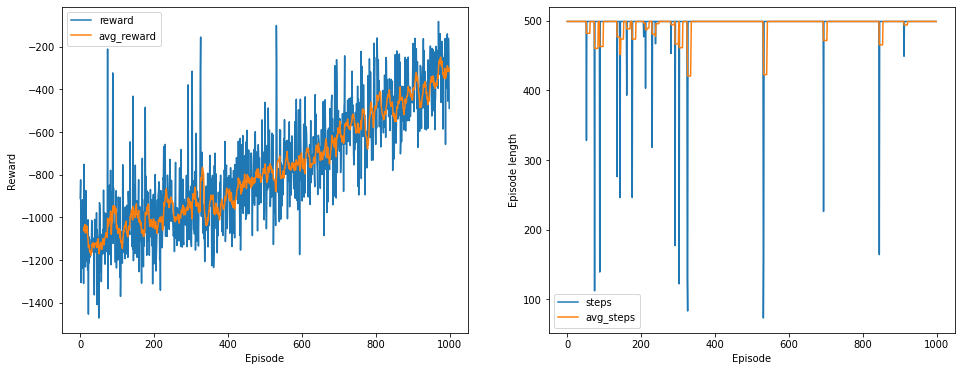

In [25]:
# Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(all_rewards, label="reward")
plt.plot(smoothed_rewards, label="avg_reward")
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

plt.subplot(1,2,2)
plt.plot(all_lengths, label="steps")
plt.plot(average_lengths, label="avg_steps")
plt.xlabel('Episode')
plt.ylabel('Episode length')
plt.legend()
plt.show()

99# reward=9, done=False 

 Turn off (2,0)
ooo
oo*
ooo



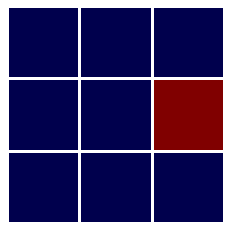

In [29]:
state = env.reset()
env.render()
for i in range(100):
    clear_output(wait=True)
    _value, policy_dist = actor_critic.forward(env.decode(state).ravel())
    a = np.argmax(policy_dist.detach().numpy())
    y, r, d, _ = env.step(a)
    print(f"{i}# reward={r}, done={d} \n")
    env.render(plot=True)
    state=y
    if d:
        print(i)
        break
    time.sleep(0.3)


In [41]:
# Save network
torch.save(actor_critic.state_dict(), "models/alarm_a2c.pth")

In [42]:
# Load network
hidden_size = 256
num_inputs = env.decode(env.reset()).size # the pixels
num_outputs = env.action_space.n

ac = ActorCritic(num_inputs, num_outputs, hidden_size)

ac.load_state_dict(torch.load("models/alarm_a2c.pth"))


<All keys matched successfully>

9# reward=9, done=False 

 Turn off (0,2)
*oo
ooo
ooo



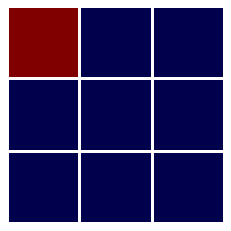

In [43]:
# play from loaded
state = env.reset()
env.render()
for i in range(10):
    clear_output(wait=True)
    _value, policy_dist = ac.forward(env.decode(state).ravel())
    a = np.argmax(policy_dist.detach().numpy())
    y, r, d, _ = env.step(a)
    print(f"{i}# reward={r}, done={d} \n")
    env.render(plot=True)
    state=y
    if d:
        print(i)
        break
    time.sleep(0.3)